# DPG for Cartpole


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [6]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.4868042623325435 -2.6142157809994244
actions: 1 0
rewards: 1.0 1.0


In [7]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [8]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [9]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [10]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [11]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [12]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [13]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                              labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob * targetQs) # DPG
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states) # tgtQs
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True) # Qs
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    rates = tf.reshape(rates, shape=[-1, 1])
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=rates)) # 0-1
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [14]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [15]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [26]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), # ==  len(self.rates)
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [27]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [28]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e2)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [29]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [30]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [32]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dloss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111):
        total_reward = 0 # each episode
        gloss_batch, dlossA_batch, dlossQ_batch= [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        idx_arr = np.arange(memory_size// batch_size)

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
                #print(action)
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits) # adding epsilon*noise
                #print(action)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            gloss, dlossA, dlossQ, _, _, _ = sess.run([model.g_loss, model.d_lossA, model.d_lossQ, 
                                                       model.g_opt, model.d_optA, model.d_optQ],
                                                      feed_dict = {model.states: states, 
                                                                   model.actions: actions,
                                                                   model.targetQs: targetQs, 
                                                                   model.rates: rates})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        #gloss_list.append([ep, np.mean(gloss_batch)])
        #dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:56.0000 R:56.0000 rate:0.1120 gloss:0.6538 dlossA:0.6936 dlossQ:1.0110 exploreP:0.9945
Episode:1 meanR:41.5000 R:27.0000 rate:0.0540 gloss:0.6705 dlossA:0.6851 dlossQ:1.0880 exploreP:0.9918
Episode:2 meanR:33.0000 R:16.0000 rate:0.0320 gloss:0.6598 dlossA:0.6930 dlossQ:1.0121 exploreP:0.9902
Episode:3 meanR:28.0000 R:13.0000 rate:0.0260 gloss:0.6456 dlossA:0.6870 dlossQ:1.0104 exploreP:0.9890
Episode:4 meanR:26.2000 R:19.0000 rate:0.0380 gloss:0.6499 dlossA:0.6977 dlossQ:0.9968 exploreP:0.9871
Episode:5 meanR:23.8333 R:12.0000 rate:0.0240 gloss:0.6515 dlossA:0.6837 dlossQ:1.0450 exploreP:0.9859
Episode:6 meanR:23.4286 R:21.0000 rate:0.0420 gloss:0.6635 dlossA:0.7052 dlossQ:1.0044 exploreP:0.9839
Episode:7 meanR:22.1250 R:13.0000 rate:0.0260 gloss:0.6103 dlossA:0.6769 dlossQ:0.9728 exploreP:0.9826
Episode:8 meanR:21.5556 R:17.0000 rate:0.0340 gloss:0.6466 dlossA:0.6974 dlossQ:0.9961 exploreP:0.9810
Episode:9 meanR:21.3000 R:19.0000 rate:0.0380 gloss:0.6551 dlossA:0.6778 

Episode:79 meanR:23.2750 R:27.0000 rate:0.0540 gloss:0.6748 dlossA:0.7001 dlossQ:1.0200 exploreP:0.8318
Episode:80 meanR:23.4938 R:41.0000 rate:0.0820 gloss:0.6698 dlossA:0.7152 dlossQ:0.9639 exploreP:0.8284
Episode:81 meanR:24.0366 R:68.0000 rate:0.1360 gloss:0.6577 dlossA:0.7065 dlossQ:0.9686 exploreP:0.8229
Episode:82 meanR:23.9398 R:16.0000 rate:0.0320 gloss:0.6351 dlossA:0.7039 dlossQ:0.9141 exploreP:0.8216
Episode:83 meanR:24.5714 R:77.0000 rate:0.1540 gloss:0.6656 dlossA:0.7106 dlossQ:0.9657 exploreP:0.8154
Episode:84 meanR:24.5412 R:22.0000 rate:0.0440 gloss:0.6447 dlossA:0.6853 dlossQ:1.0169 exploreP:0.8136
Episode:85 meanR:24.4651 R:18.0000 rate:0.0360 gloss:0.6606 dlossA:0.7154 dlossQ:0.9493 exploreP:0.8122
Episode:86 meanR:24.7241 R:47.0000 rate:0.0940 gloss:0.6565 dlossA:0.7079 dlossQ:0.9606 exploreP:0.8084
Episode:87 meanR:24.6250 R:16.0000 rate:0.0320 gloss:0.6452 dlossA:0.6851 dlossQ:1.0042 exploreP:0.8071
Episode:88 meanR:25.2360 R:79.0000 rate:0.1580 gloss:0.6512 dlos

Episode:158 meanR:36.2700 R:56.0000 rate:0.1120 gloss:0.6424 dlossA:0.7084 dlossQ:0.9275 exploreP:0.6167
Episode:159 meanR:36.3800 R:56.0000 rate:0.1120 gloss:0.6586 dlossA:0.7100 dlossQ:0.9406 exploreP:0.6133
Episode:160 meanR:36.6100 R:42.0000 rate:0.0840 gloss:0.6619 dlossA:0.7251 dlossQ:0.9055 exploreP:0.6108
Episode:161 meanR:36.5800 R:13.0000 rate:0.0260 gloss:0.6433 dlossA:0.7108 dlossQ:0.8960 exploreP:0.6100
Episode:162 meanR:37.4000 R:100.0000 rate:0.2000 gloss:0.6463 dlossA:0.7093 dlossQ:0.9126 exploreP:0.6040
Episode:163 meanR:37.3200 R:11.0000 rate:0.0220 gloss:0.6694 dlossA:0.7248 dlossQ:0.9295 exploreP:0.6034
Episode:164 meanR:37.8400 R:81.0000 rate:0.1620 gloss:0.6578 dlossA:0.7214 dlossQ:0.9047 exploreP:0.5986
Episode:165 meanR:38.0500 R:49.0000 rate:0.0980 gloss:0.6436 dlossA:0.7112 dlossQ:0.9272 exploreP:0.5957
Episode:166 meanR:37.9400 R:21.0000 rate:0.0420 gloss:0.6397 dlossA:0.6987 dlossQ:0.9401 exploreP:0.5945
Episode:167 meanR:38.3500 R:72.0000 rate:0.1440 gloss:

Episode:236 meanR:58.9200 R:41.0000 rate:0.0820 gloss:0.6194 dlossA:0.7269 dlossQ:0.7945 exploreP:0.3830
Episode:237 meanR:58.9800 R:83.0000 rate:0.1660 gloss:0.6124 dlossA:0.7246 dlossQ:0.7800 exploreP:0.3799
Episode:238 meanR:59.0400 R:54.0000 rate:0.1080 gloss:0.6450 dlossA:0.7403 dlossQ:0.8137 exploreP:0.3779
Episode:239 meanR:58.6400 R:39.0000 rate:0.0780 gloss:0.6260 dlossA:0.7258 dlossQ:0.8180 exploreP:0.3765
Episode:240 meanR:59.4600 R:102.0000 rate:0.2040 gloss:0.6092 dlossA:0.7268 dlossQ:0.7818 exploreP:0.3727
Episode:241 meanR:61.0900 R:184.0000 rate:0.3680 gloss:0.6151 dlossA:0.7318 dlossQ:0.7731 exploreP:0.3661
Episode:242 meanR:61.5100 R:72.0000 rate:0.1440 gloss:0.6298 dlossA:0.7352 dlossQ:0.7988 exploreP:0.3636
Episode:243 meanR:61.8300 R:67.0000 rate:0.1340 gloss:0.6400 dlossA:0.7464 dlossQ:0.7827 exploreP:0.3612
Episode:244 meanR:62.2500 R:74.0000 rate:0.1480 gloss:0.6178 dlossA:0.7314 dlossQ:0.7883 exploreP:0.3586
Episode:245 meanR:62.5700 R:67.0000 rate:0.1340 gloss

Episode:314 meanR:88.4800 R:77.0000 rate:0.1540 gloss:0.6574 dlossA:0.8112 dlossQ:0.6732 exploreP:0.1932
Episode:315 meanR:88.5800 R:48.0000 rate:0.0960 gloss:0.6213 dlossA:0.7557 dlossQ:0.6987 exploreP:0.1923
Episode:316 meanR:88.4400 R:43.0000 rate:0.0860 gloss:0.6415 dlossA:0.7746 dlossQ:0.6928 exploreP:0.1915
Episode:317 meanR:89.0700 R:151.0000 rate:0.3020 gloss:nan dlossA:nan dlossQ:nan exploreP:0.1888
Episode:318 meanR:89.8400 R:133.0000 rate:0.2660 gloss:0.6129 dlossA:0.7609 dlossQ:0.6776 exploreP:0.1864
Episode:319 meanR:89.3700 R:69.0000 rate:0.1380 gloss:0.5934 dlossA:0.7601 dlossQ:0.6572 exploreP:0.1852
Episode:320 meanR:89.9000 R:128.0000 rate:0.2560 gloss:0.6104 dlossA:0.7728 dlossQ:0.6494 exploreP:0.1830
Episode:321 meanR:88.0800 R:43.0000 rate:0.0860 gloss:0.5558 dlossA:0.7316 dlossQ:0.6561 exploreP:0.1823
Episode:322 meanR:87.1000 R:32.0000 rate:0.0640 gloss:0.6597 dlossA:0.8260 dlossQ:0.6367 exploreP:0.1817
Episode:323 meanR:87.6700 R:109.0000 rate:0.2180 gloss:0.6070

Episode:392 meanR:79.6700 R:75.0000 rate:0.1500 gloss:0.6111 dlossA:0.8075 dlossQ:0.5759 exploreP:0.1113
Episode:393 meanR:79.1800 R:57.0000 rate:0.1140 gloss:0.6127 dlossA:0.8219 dlossQ:0.5660 exploreP:0.1107
Episode:394 meanR:77.9300 R:43.0000 rate:0.0860 gloss:0.5631 dlossA:0.7922 dlossQ:0.5427 exploreP:0.1103
Episode:395 meanR:78.0200 R:63.0000 rate:0.1260 gloss:0.5506 dlossA:0.7804 dlossQ:0.5663 exploreP:0.1096
Episode:396 meanR:77.6700 R:48.0000 rate:0.0960 gloss:0.5747 dlossA:0.7885 dlossQ:0.5550 exploreP:0.1092
Episode:397 meanR:78.5500 R:120.0000 rate:0.2400 gloss:0.6031 dlossA:0.8101 dlossQ:0.5604 exploreP:0.1080
Episode:398 meanR:77.4000 R:48.0000 rate:0.0960 gloss:0.5375 dlossA:0.7717 dlossQ:0.5432 exploreP:0.1075
Episode:399 meanR:77.6000 R:133.0000 rate:0.2660 gloss:0.5559 dlossA:0.7842 dlossQ:0.5522 exploreP:0.1062
Episode:400 meanR:76.7600 R:44.0000 rate:0.0880 gloss:0.6109 dlossA:0.8546 dlossQ:0.5540 exploreP:0.1058
Episode:401 meanR:74.8100 R:37.0000 rate:0.0740 gloss

Episode:470 meanR:66.6800 R:103.0000 rate:0.2060 gloss:0.5233 dlossA:0.7906 dlossQ:0.4833 exploreP:0.0709
Episode:471 meanR:67.2600 R:113.0000 rate:0.2260 gloss:0.5697 dlossA:0.8141 dlossQ:0.4909 exploreP:0.0702
Episode:472 meanR:67.1200 R:33.0000 rate:0.0660 gloss:0.5712 dlossA:0.8086 dlossQ:0.4845 exploreP:0.0700
Episode:473 meanR:66.8600 R:48.0000 rate:0.0960 gloss:0.5630 dlossA:0.8011 dlossQ:0.4706 exploreP:0.0697
Episode:474 meanR:66.1600 R:41.0000 rate:0.0820 gloss:0.6147 dlossA:0.8507 dlossQ:0.5204 exploreP:0.0695
Episode:475 meanR:65.9200 R:54.0000 rate:0.1080 gloss:0.5688 dlossA:0.8200 dlossQ:0.4952 exploreP:0.0692
Episode:476 meanR:65.6900 R:36.0000 rate:0.0720 gloss:0.5245 dlossA:0.7632 dlossQ:0.5007 exploreP:0.0690
Episode:477 meanR:65.5900 R:43.0000 rate:0.0860 gloss:0.5577 dlossA:0.8324 dlossQ:0.4854 exploreP:0.0687
Episode:478 meanR:65.0900 R:42.0000 rate:0.0840 gloss:0.5486 dlossA:0.8056 dlossQ:0.4983 exploreP:0.0685
Episode:479 meanR:63.9200 R:34.0000 rate:0.0680 gloss

Episode:548 meanR:68.2700 R:61.0000 rate:0.1220 gloss:0.4852 dlossA:0.8077 dlossQ:0.4722 exploreP:0.0452
Episode:549 meanR:68.0900 R:75.0000 rate:0.1500 gloss:0.5501 dlossA:0.8112 dlossQ:0.4876 exploreP:0.0449
Episode:550 meanR:67.5100 R:53.0000 rate:0.1060 gloss:0.5787 dlossA:0.8287 dlossQ:0.4645 exploreP:0.0447
Episode:551 meanR:67.4400 R:46.0000 rate:0.0920 gloss:0.5258 dlossA:0.8216 dlossQ:0.4934 exploreP:0.0446
Episode:552 meanR:67.5200 R:45.0000 rate:0.0900 gloss:0.5068 dlossA:0.7861 dlossQ:0.4609 exploreP:0.0444
Episode:553 meanR:67.5400 R:65.0000 rate:0.1300 gloss:0.5039 dlossA:0.7843 dlossQ:0.4611 exploreP:0.0442
Episode:554 meanR:67.5500 R:50.0000 rate:0.1000 gloss:0.5700 dlossA:0.8573 dlossQ:0.4592 exploreP:0.0440
Episode:555 meanR:67.4500 R:41.0000 rate:0.0820 gloss:0.5880 dlossA:0.8577 dlossQ:0.4849 exploreP:0.0439
Episode:556 meanR:68.5900 R:159.0000 rate:0.3180 gloss:0.5316 dlossA:0.8189 dlossQ:0.4588 exploreP:0.0433
Episode:557 meanR:68.5000 R:44.0000 rate:0.0880 gloss:

Episode:627 meanR:61.8700 R:57.0000 rate:0.1140 gloss:0.4717 dlossA:0.7841 dlossQ:0.4063 exploreP:0.0323
Episode:628 meanR:61.5000 R:44.0000 rate:0.0880 gloss:0.4040 dlossA:0.7753 dlossQ:0.4074 exploreP:0.0322
Episode:629 meanR:61.8500 R:80.0000 rate:0.1600 gloss:0.4719 dlossA:0.7984 dlossQ:0.4084 exploreP:0.0321
Episode:630 meanR:61.5100 R:85.0000 rate:0.1700 gloss:0.4858 dlossA:0.8089 dlossQ:0.4286 exploreP:0.0319
Episode:631 meanR:61.4400 R:42.0000 rate:0.0840 gloss:0.3850 dlossA:0.7555 dlossQ:0.4217 exploreP:0.0318
Episode:632 meanR:61.3100 R:33.0000 rate:0.0660 gloss:0.5058 dlossA:0.8042 dlossQ:0.4166 exploreP:0.0317
Episode:633 meanR:61.4800 R:59.0000 rate:0.1180 gloss:0.4894 dlossA:0.8218 dlossQ:0.4026 exploreP:0.0316
Episode:634 meanR:61.3100 R:104.0000 rate:0.2080 gloss:0.4489 dlossA:0.7724 dlossQ:0.4136 exploreP:0.0314
Episode:635 meanR:60.7300 R:49.0000 rate:0.0980 gloss:0.5261 dlossA:0.8282 dlossQ:0.3880 exploreP:0.0313
Episode:636 meanR:60.5200 R:134.0000 rate:0.2680 gloss

Episode:705 meanR:62.6900 R:56.0000 rate:0.1120 gloss:0.3325 dlossA:0.7275 dlossQ:0.3450 exploreP:0.0236
Episode:706 meanR:62.8600 R:62.0000 rate:0.1240 gloss:0.3082 dlossA:0.7160 dlossQ:0.3498 exploreP:0.0235
Episode:707 meanR:61.8500 R:37.0000 rate:0.0740 gloss:0.3662 dlossA:0.7388 dlossQ:0.3627 exploreP:0.0235
Episode:708 meanR:61.9300 R:58.0000 rate:0.1160 gloss:0.2991 dlossA:0.7121 dlossQ:0.3518 exploreP:0.0234
Episode:709 meanR:62.7500 R:134.0000 rate:0.2680 gloss:0.3472 dlossA:0.7287 dlossQ:0.3460 exploreP:0.0232
Episode:710 meanR:61.7700 R:35.0000 rate:0.0700 gloss:0.3703 dlossA:0.7459 dlossQ:0.3486 exploreP:0.0232
Episode:711 meanR:61.8600 R:60.0000 rate:0.1200 gloss:0.3477 dlossA:0.7198 dlossQ:0.3790 exploreP:0.0231
Episode:712 meanR:61.3300 R:37.0000 rate:0.0740 gloss:0.3187 dlossA:0.7011 dlossQ:0.3618 exploreP:0.0230
Episode:713 meanR:61.2400 R:39.0000 rate:0.0780 gloss:0.3154 dlossA:0.7307 dlossQ:0.3302 exploreP:0.0230
Episode:714 meanR:62.1300 R:122.0000 rate:0.2440 gloss

Episode:783 meanR:63.0600 R:101.0000 rate:0.2020 gloss:0.3051 dlossA:0.7211 dlossQ:0.3311 exploreP:0.0184
Episode:784 meanR:62.9400 R:35.0000 rate:0.0700 gloss:0.3195 dlossA:0.7328 dlossQ:0.3300 exploreP:0.0184
Episode:785 meanR:62.9900 R:42.0000 rate:0.0840 gloss:0.2938 dlossA:0.7071 dlossQ:0.3334 exploreP:0.0184
Episode:786 meanR:64.2100 R:155.0000 rate:0.3100 gloss:0.2924 dlossA:0.7072 dlossQ:0.3387 exploreP:0.0182
Episode:787 meanR:64.2000 R:63.0000 rate:0.1260 gloss:0.2816 dlossA:0.7087 dlossQ:0.3605 exploreP:0.0182
Episode:788 meanR:64.6300 R:100.0000 rate:0.2000 gloss:0.2966 dlossA:0.7223 dlossQ:0.3507 exploreP:0.0181
Episode:789 meanR:64.7600 R:66.0000 rate:0.1320 gloss:0.3080 dlossA:0.7157 dlossQ:0.3367 exploreP:0.0181
Episode:790 meanR:64.4600 R:39.0000 rate:0.0780 gloss:0.2944 dlossA:0.7186 dlossQ:0.3440 exploreP:0.0180
Episode:791 meanR:65.1300 R:128.0000 rate:0.2560 gloss:0.2770 dlossA:0.7093 dlossQ:0.3701 exploreP:0.0179
Episode:792 meanR:64.2600 R:74.0000 rate:0.1480 glo

Episode:861 meanR:61.0100 R:82.0000 rate:0.1640 gloss:0.2270 dlossA:0.6938 dlossQ:0.3278 exploreP:0.0152
Episode:862 meanR:61.2600 R:67.0000 rate:0.1340 gloss:0.2462 dlossA:0.6991 dlossQ:0.3195 exploreP:0.0151
Episode:863 meanR:61.4000 R:51.0000 rate:0.1020 gloss:0.2162 dlossA:0.6882 dlossQ:0.3214 exploreP:0.0151
Episode:864 meanR:62.0200 R:94.0000 rate:0.1880 gloss:0.2204 dlossA:0.6747 dlossQ:0.3363 exploreP:0.0151
Episode:865 meanR:61.8800 R:45.0000 rate:0.0900 gloss:0.2301 dlossA:0.6939 dlossQ:0.3228 exploreP:0.0150
Episode:866 meanR:61.7000 R:44.0000 rate:0.0880 gloss:0.2491 dlossA:0.6997 dlossQ:0.3074 exploreP:0.0150
Episode:867 meanR:61.6500 R:36.0000 rate:0.0720 gloss:0.2536 dlossA:0.7007 dlossQ:0.3298 exploreP:0.0150
Episode:868 meanR:62.2800 R:102.0000 rate:0.2040 gloss:0.2049 dlossA:0.6666 dlossQ:0.3652 exploreP:0.0149
Episode:869 meanR:62.3500 R:55.0000 rate:0.1100 gloss:0.2446 dlossA:0.6745 dlossQ:0.3362 exploreP:0.0149
Episode:870 meanR:61.8600 R:32.0000 rate:0.0640 gloss:

Episode:939 meanR:59.2000 R:79.0000 rate:0.1580 gloss:0.2188 dlossA:0.6701 dlossQ:0.3364 exploreP:0.0133
Episode:940 meanR:58.8300 R:43.0000 rate:0.0860 gloss:0.1999 dlossA:0.6665 dlossQ:0.3130 exploreP:0.0133
Episode:941 meanR:58.4700 R:39.0000 rate:0.0780 gloss:0.1789 dlossA:0.6739 dlossQ:0.2998 exploreP:0.0132
Episode:942 meanR:58.5600 R:51.0000 rate:0.1020 gloss:0.1755 dlossA:0.6678 dlossQ:0.3550 exploreP:0.0132
Episode:943 meanR:58.4000 R:45.0000 rate:0.0900 gloss:0.2119 dlossA:0.6750 dlossQ:0.3182 exploreP:0.0132
Episode:944 meanR:58.3500 R:46.0000 rate:0.0920 gloss:0.2094 dlossA:0.6588 dlossQ:0.3488 exploreP:0.0132
Episode:945 meanR:58.3500 R:49.0000 rate:0.0980 gloss:0.1897 dlossA:0.6652 dlossQ:0.3330 exploreP:0.0132
Episode:946 meanR:58.8400 R:90.0000 rate:0.1800 gloss:0.2251 dlossA:0.6704 dlossQ:0.3498 exploreP:0.0132
Episode:947 meanR:58.8600 R:83.0000 rate:0.1660 gloss:0.1705 dlossA:0.6771 dlossQ:0.3304 exploreP:0.0131
Episode:948 meanR:59.1100 R:60.0000 rate:0.1200 gloss:0

Episode:1017 meanR:57.4500 R:143.0000 rate:0.2860 gloss:0.1238 dlossA:0.6439 dlossQ:0.3205 exploreP:0.0121
Episode:1018 meanR:57.5400 R:58.0000 rate:0.1160 gloss:0.1494 dlossA:0.6406 dlossQ:0.3182 exploreP:0.0121
Episode:1019 meanR:57.2400 R:73.0000 rate:0.1460 gloss:0.1802 dlossA:0.6545 dlossQ:0.3181 exploreP:0.0121
Episode:1020 meanR:56.5000 R:39.0000 rate:0.0780 gloss:0.1254 dlossA:0.6370 dlossQ:0.2926 exploreP:0.0121
Episode:1021 meanR:56.4200 R:35.0000 rate:0.0700 gloss:0.0797 dlossA:0.6554 dlossQ:0.3002 exploreP:0.0121
Episode:1022 meanR:56.7400 R:111.0000 rate:0.2220 gloss:0.1096 dlossA:0.6427 dlossQ:0.3375 exploreP:0.0121
Episode:1023 meanR:56.8300 R:40.0000 rate:0.0800 gloss:0.1457 dlossA:0.6513 dlossQ:0.3091 exploreP:0.0120
Episode:1024 meanR:56.4700 R:45.0000 rate:0.0900 gloss:0.1134 dlossA:0.6553 dlossQ:0.3624 exploreP:0.0120
Episode:1025 meanR:56.5800 R:57.0000 rate:0.1140 gloss:0.1789 dlossA:0.6549 dlossQ:0.3152 exploreP:0.0120
Episode:1026 meanR:56.3200 R:53.0000 rate:0.

Episode:1095 meanR:63.4900 R:61.0000 rate:0.1220 gloss:0.0930 dlossA:0.6326 dlossQ:0.2913 exploreP:0.0113
Episode:1096 meanR:63.5500 R:40.0000 rate:0.0800 gloss:0.1538 dlossA:0.6424 dlossQ:0.2680 exploreP:0.0113
Episode:1097 meanR:63.5900 R:57.0000 rate:0.1140 gloss:0.1639 dlossA:0.6439 dlossQ:0.2820 exploreP:0.0113
Episode:1098 meanR:63.3400 R:44.0000 rate:0.0880 gloss:0.1395 dlossA:0.6395 dlossQ:0.2652 exploreP:0.0113
Episode:1099 meanR:63.3900 R:44.0000 rate:0.0880 gloss:0.1657 dlossA:0.6542 dlossQ:0.2582 exploreP:0.0113
Episode:1100 meanR:63.9000 R:92.0000 rate:0.1840 gloss:0.1161 dlossA:0.6333 dlossQ:0.2781 exploreP:0.0112
Episode:1101 meanR:63.9200 R:50.0000 rate:0.1000 gloss:0.1201 dlossA:0.6357 dlossQ:0.2642 exploreP:0.0112
Episode:1102 meanR:64.0000 R:67.0000 rate:0.1340 gloss:0.1950 dlossA:0.6417 dlossQ:0.2925 exploreP:0.0112
Episode:1103 meanR:63.4800 R:35.0000 rate:0.0700 gloss:0.0816 dlossA:0.6339 dlossQ:0.2631 exploreP:0.0112
Episode:1104 meanR:63.1700 R:43.0000 rate:0.08

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

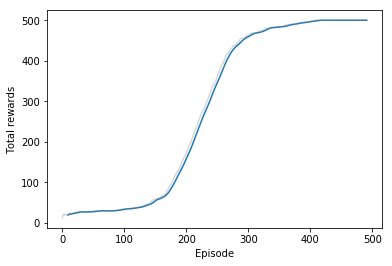

In [62]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

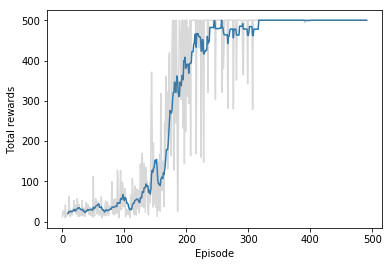

In [63]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [65]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [67]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.